<center> 

# EN3160 Assignment 2
## Fitting

### Priyankan V. - 210498T
</center>

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max
from skimage import transform
from scipy.optimize import minimize
from scipy import linalg, optimize
from matplotlib.patches import Circle
import random
import math


%matplotlib inline

#### Question 1

In [9]:
img1 = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
assert img1 is not None, 'Image not found'

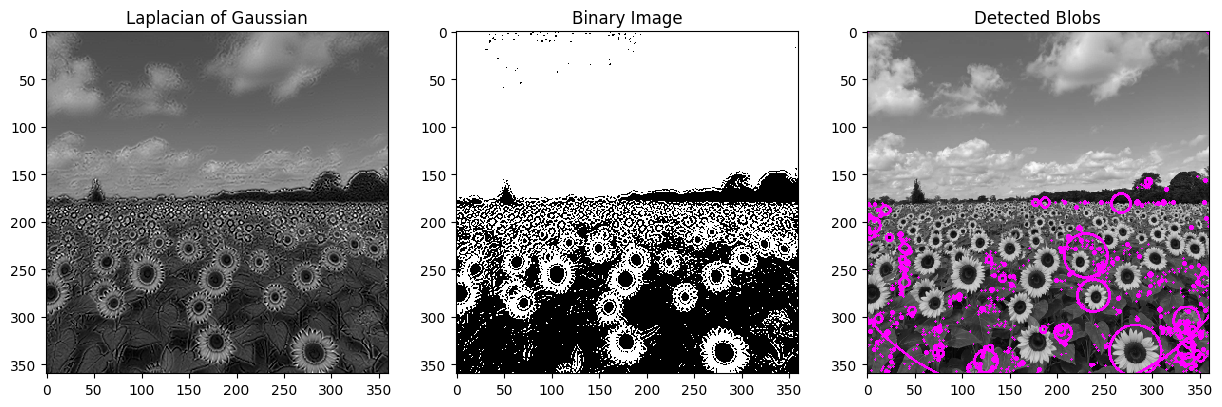

Number of detected blobs: 624


In [10]:
def generate_gaussian_kernel(dim, sigma_val, display=False):
    """Generate a 2D Gaussian kernel with a specified size and sigma."""
    axis_1D = np.linspace(-(dim // 2), dim // 2, dim)
    kernel_1D = np.exp(-(axis_1D ** 2) / (2 * sigma_val ** 2)) / (sigma_val * np.sqrt(2 * np.pi))
    kernel_2D = np.outer(kernel_1D, kernel_1D)

    kernel_2D /= kernel_2D.max()  # Normalize the kernel so its max value is 1.

    if display:
        plt.imshow(kernel_2D, cmap='gray', interpolation='none')
        plt.title("Gaussian Kernel")
        plt.show()

    return kernel_2D

# Parameters
sigma_val = 0.64

# Create a Gaussian kernel
gaussian_kernel_2D = generate_gaussian_kernel(5, sigma_val, display=False)

# Calculate the Laplacian of the Gaussian kernel
laplacian_of_gaussian_kernel = cv.Laplacian(gaussian_kernel_2D, cv.CV_64F) * sigma_val**2

# Apply the Laplacian of Gaussian kernel to the input image
laplacian_filtered_image = cv.filter2D(img1, -1, laplacian_of_gaussian_kernel)

# Threshold the filtered image
threshold = 75  # Modify as necessary
_, binary_output = cv.threshold(np.abs(laplacian_filtered_image), threshold, 255, cv.THRESH_BINARY)

# Extract contours from the binary image
contour_list, _ = cv.findContours(binary_output.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw detected contours as circles on the original image
final_image = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)

for contour in contour_list:
    # Compute the center and radius for each detected blob
    (center_point, radius) = cv.minEnclosingCircle(contour)
    center_coords = (int(center_point[0]), int(center_point[1]))
    radius = int(radius)

    # Draw circles on the image
    cv.circle(final_image, center_coords, radius, (255, 0, 255), 2)  # Purple circles, thickness=2

# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(laplacian_filtered_image, cmap='gray', interpolation='none')
plt.title("Laplacian of Gaussian")

plt.subplot(1, 3, 2)
plt.imshow(binary_output, cmap='gray', interpolation='none')
plt.title("Binary Image")

plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray', interpolation='none')
plt.title("Detected Blobs")

plt.show()

# Display the number of detected blobs
print(f"Number of detected blobs: {len(contour_list)}")


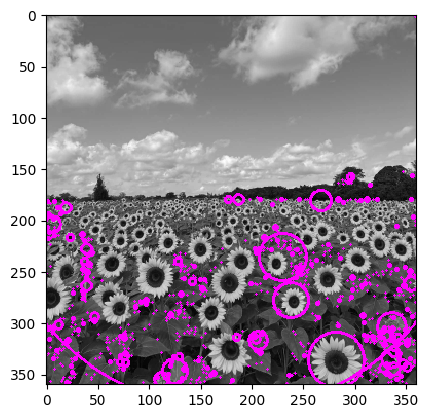

In [11]:
plt.imshow(final_image, interpolation='none', cmap='gray')
plt.show()

#### Question 2

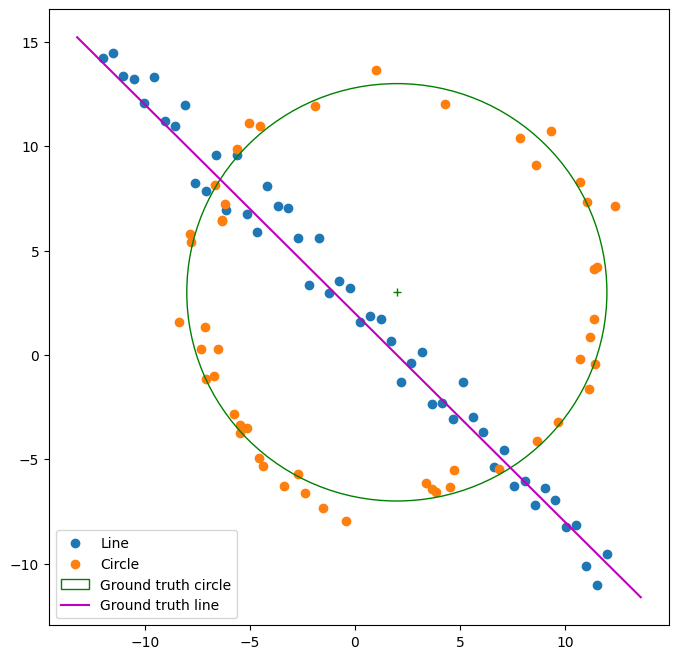

In [22]:
np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()

a. 

In [23]:
def line_tls(params, indices, X):
    # Extract line parameters
    a, b, c = params[0], params[1], params[2]
    # Calculate the sum of squared distances from the points to the line
    residuals = a * X[indices, 0] + b * X[indices, 1] - c
    return np.sum(np.square(residuals))

def consensus_line(X, params, threshold):
    # Extract line parameters
    a, b, c = params[0], params[1], params[2]
    # Compute the error as the absolute distance from points to the line
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - c)
    # Return a boolean array indicating whether each point is an inlier
    return errors < threshold

def g(params):
    # Constraint function to ensure the parameters satisfy a unit circle constraint
    return params[0]**2 + params[1]**2 - 1

# Define constraints for optimization
cons = ({'type': 'eq', 'fun': g})


In [24]:
# Initialize parameters for the line-fitting RANSAC algorithm
N = X_line.shape[0]
X_ = X_line
tolerance = 0.8  # Maximum distance for a point to be considered an inlier
min_inliers = int(0.4 * N)  # Minimum number of inliers required
sample_size = 2  # Two points define a line

# Initialize variables to track the best model and inliers
best_line_model = None
best_inliers = []
best_sample = []
smallest_error = float('inf')
iterations = 0
max_iterations = 100
sampled_result = []

# RANSAC loop for line fitting
while iterations < max_iterations:
    # Randomly select two points to fit a line
    selected_indices = np.random.randint(0, N, sample_size)
    initial_guess = np.array([1, 1, 0])  # Initial guess for the line parameters

    # Minimize the total least squares error for the line using the selected points
    result = minimize(fun=line_tls, args=(selected_indices, X_), x0=initial_guess, tol=1e-6, constraints=cons, options={'disp': False})
    
    # Find inliers for the current line model
    current_inliers = consensus_line(X_, result.x, tolerance)

    # Check if the number of inliers exceeds the required threshold
    if current_inliers.sum() > min_inliers:
        # Refine the model using all inliers
        refined_guess = result.x
        refined_result = minimize(fun=line_tls, args=(current_inliers, X_), x0=refined_guess, tol=1e-6, constraints=cons, options={'disp': False})

        # If the refined model has a lower error, update the best model
        if refined_result.fun < smallest_error:
            best_line_model = refined_result.x
            smallest_error = refined_result.fun
            best_sample = X_[selected_indices, :]
            sampled_result = refined_guess
            best_inliers = current_inliers

    # Increment the iteration count
    iterations += 1

In [25]:
def dist_circle(params, X, indices):
    # Unpack circle parameters
    xc, yc, radius = params
    # Calculate the sum of squared distances from the points to the circle's perimeter
    squared_differences = np.square(np.sqrt((X[indices, 0] - xc)**2 + (X[indices, 1] - yc)**2) - radius)
    return np.sum(squared_differences)

def consensus_circle(X, params, threshold):
    # Unpack circle parameters
    xc, yc, radius = params
    # Compute absolute errors between the distance of points from the circle center and the circle radius
    distances = np.sqrt((X[:, 0] - xc)**2 + (X[:, 1] - yc)**2)
    errors = np.abs(distances - radius)
    # Return boolean array where errors are within the threshold
    return errors < threshold

In [26]:
tolerance = 1.2  # Maximum allowable error for inliers
min_inliers = int(0.4 * N)  # Minimum number of inliers for a valid model
sample_size = 3  # Three points needed to define a circle

N = X_circ.shape[0]
X_ = X_circ

# Initialize variables to store the best model and inliers
best_circle_model = None
best_circle_inliers = []
best_circle_sample = []
lowest_error = float('inf')
iterations = 0
max_iterations = 200

# RANSAC loop
while iterations < max_iterations:
    # Randomly select points to estimate the circle model
    random_indices = np.random.randint(0, N, sample_size)
    initial_guess = np.array([2, 3, 1])  # Initial guess for circle parameters
    
    # Minimize the distance to the circle using the selected sample
    result = minimize(fun=dist_circle, args=(X_, random_indices), x0=initial_guess, tol=1e-6, options={'disp': False})
    
    # Find the inliers for the current model
    current_inliers = consensus_circle(X_, result.x, tolerance)
    
    # If the number of inliers is sufficient, refine the model using all inliers
    if current_inliers.sum() > min_inliers:
        refined_guess = result.x
        refined_result = minimize(fun=dist_circle, args=(X_, current_inliers), x0=refined_guess, tol=1e-6, options={'disp': False})
        
        # If the refined model has a lower error, update the best model
        if refined_result.fun < lowest_error:
            best_circle_model = refined_result.x
            lowest_error = refined_result.fun
            best_circle_sample = X_[random_indices, :]
            best_circle_inliers = current_inliers
    
    # Increment the iteration count
    iterations += 1

NameError: name 'best_inliers_line' is not defined

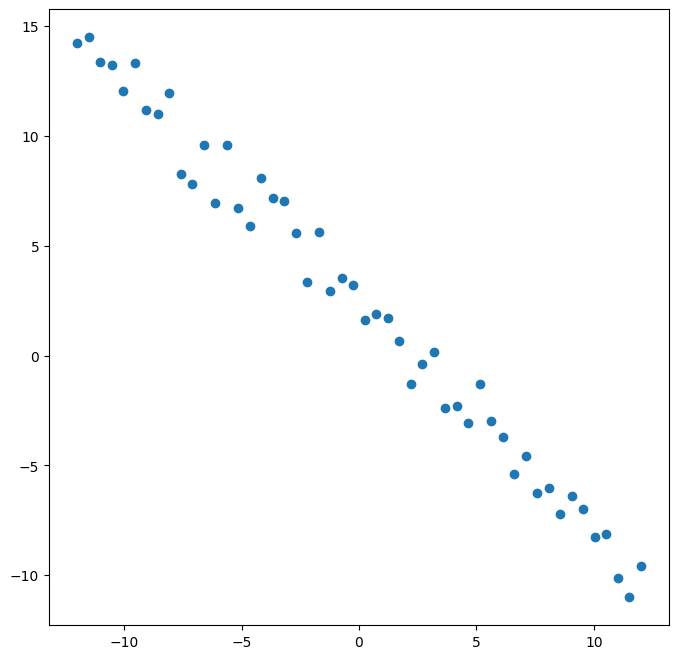

In [29]:
# Create a subplot for visualizing the results
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot for all the line points and the inliers
ax.scatter(X_line[:, 0], X_line[:, 1], label='All points on line')
ax.scatter(X_[best_inliers_line, 0], X_[best_inliers_line, 1], color='yellow', label='Identified inliers')
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], color='red', label='Optimal line sample')

# Plotting RANSAC line model
x_range = np.array(ax.get_xlim())
y_line_ransac = (-best_model_line[1] * x_range + best_model_line[2]) / best_model_line[1]
ax.plot(x_range, y_line_ransac, label='RANSAC line model')

# Plotting the ground truth line
y_line_ground_truth = m * x_range + b
ax.plot(x_range, y_line_ground_truth, color='magenta', label='True line')

# Scatter plot for all circle points and the inliers
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='All points on circle')
ax.scatter(X_[best_inliers_circle, 0], X_[best_inliers_circle, 1], color='yellow', label='Circle inliers')
ax.scatter(best_sample_circle[:, 0], best_sample_circle[:, 1], color='magenta', label='Best circle sample')

# Draw RANSAC circle model
ransac_circle = plt.Circle((best_model_circle[0], best_model_circle[1]), best_model_circle[2], color='blue', fill=False, label='RANSAC circle')

# Draw ground truth circle
ground_truth_circle = plt.Circle((x0_gt, y0_gt), 10, color='green', fill=False, label='True circle')

# Add the circles to the plot
ax.add_artist(ransac_circle)
ax.add_artist(ground_truth_circle)

# Add a legend and display the plot
plt.legend()
plt.show()

#### Question 3

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

number_of_points = 4
n = 0
architectural_points = np.empty((number_of_points,2))

# Load your architectural image and flag image
architectural_image = cv.imread('images/burj.jpg', cv.IMREAD_COLOR)
architectural_image1 = cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB)

flag_image = cv.imread('images/slflag.jpg', cv.IMREAD_COLOR)
# flag_image = cv.cvtColor(flag_image, cv.COLOR_BGR2RGB)

# Mouse callback function
def draw_circle(event,x,y,flags,param):
    global n
    architectural_points = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        architectural_points[n] = (x,y)
        n += 1

# Getting the mouse points of the base image
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [architectural_points, architectural_image]
cv.setMouseCallback('Image',draw_circle, param)
while(1):
    cv.imshow('Image', architectural_image)
    if n == number_of_points:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break

# Define the corresponding points on the flag image
# These points should form a rectangle to match the planar surface
flag_points = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(flag_points, architectural_points)

# Warp the flag image to match the architectural image using the homography
flag_warped = cv.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the two images (you can adjust the blending method and parameters)
blended_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

cv.imshow('Superimposed Image', blended_image)
cv.waitKey(0)
cv.destroyAllWindows()


In [3]:
import cv2 as cv
import numpy as np

# Number of points to collect from the architectural image
num_points = 4
point_counter = 0
architectural_coords = np.empty((num_points, 2))

# Load the architectural image and the flag image
arch_image = cv.imread('images/005.jpg', cv.IMREAD_COLOR)
italy_flag = cv.imread('images/flag.png', cv.IMREAD_COLOR)

# Mouse callback function to collect points
def mark_point(event, x, y, flags, params):
    global point_counter
    coords_array = params[0]
    if event == cv.EVENT_LBUTTONDOWN and point_counter < num_points:
        cv.circle(params[1], (x, y), 5, (255, 0, 0), -1)  # Draw a circle on the image
        coords_array[point_counter] = (x, y)  # Store the clicked coordinates
        point_counter += 1  # Increment the point counter

# Set up the display window for the architectural image
cv.namedWindow('Architectural Image', cv.WINDOW_AUTOSIZE)
params = [architectural_coords, arch_image]
cv.setMouseCallback('Architectural Image', mark_point, params)

# Display the image and wait for mouse clicks
while True:
    cv.imshow('Architectural Image', arch_image)
    if point_counter == num_points:  # Exit the loop after collecting enough points
        break
    if cv.waitKey(20) & 0xFF == 27:  # Allow escape key to exit
        break

# Define the corresponding points on the flag image (forming a rectangle)
flag_corners = np.array([[0, 0], 
                         [italy_flag.shape[1], 0], 
                         [italy_flag.shape[1], italy_flag.shape[0]], 
                         [0, italy_flag.shape[0]]], dtype=np.float32)

# Calculate the homography matrix to align the flag with the architectural image
homography_matrix, _ = cv.findHomography(flag_corners, architectural_coords)

# Warp the flag image to fit the architectural image using the computed homography
warped_flag = cv.warpPerspective(italy_flag, homography_matrix, 
                                  (arch_image.shape[1], arch_image.shape[0]))

# Blend the two images together with specified weights
final_image = cv.addWeighted(arch_image, 1, warped_flag, 0.7, 0)

# Show the final blended image
cv.imshow('Blended Result', final_image)
cv.waitKey(0)
cv.destroyAllWindows()


#### Question 4


a.

In [49]:
def sift_feature_matching(img1, img5, plot=False):
    # Initialize SIFT detector
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)

    # Detect keypoints and compute descriptors
    kp1, desc1 = sift.detectAndCompute(img1, None)
    kp5, desc5 = sift.detectAndCompute(img5, None)

    # Match features using BFMatcher and apply ratio test
    matches = cv.BFMatcher().knnMatch(desc1, desc5, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Plot features and matches if requested
    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv.drawKeypoints(img1, kp1, None))
        plt.title("Image 1 SIFT features")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv.drawKeypoints(img5, kp5, None))
        plt.title("Image 5 SIFT features")
        plt.axis('off')
        plt.tight_layout()

        plt.figure(figsize=(15, 10))
        plt.imshow(cv.drawMatches(img1, kp1, img5, kp5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
        plt.axis('off')
        plt.tight_layout()

    return good_matches, kp1, kp5


In [51]:
def get_inliers(src, dst, tform, thres):
    errors = np.linalg.norm(tform(src) - dst, axis=1)
    return np.where(errors < thres)[0]

In [52]:
def find_best_homography(good_matches, keypoints1, keypoints5):
    # Extract matching points
    src_full = np.array([keypoints1[m.queryIdx].pt for m in good_matches])
    dst_full = np.array([keypoints5[m.trainIdx].pt for m in good_matches])

    # RANSAC setup
    best_homography, best_inliers = None, []
    thres, d, iters, num_points = 1, 0.5 * len(good_matches), 200, 4

    for _ in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace=False)
        src_points = np.array([keypoints1[m.queryIdx].pt for m in chosen_matches])
        dst_points = np.array([keypoints5[m.trainIdx].pt for m in chosen_matches])

        # Estimate transformation and find inliers
        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)

        if len(inliers) > len(best_inliers):
            best_homography, best_inliers = tform, inliers

    print(f'Best no. of inliers = {len(best_inliers)}')
    return best_homography, best_inliers


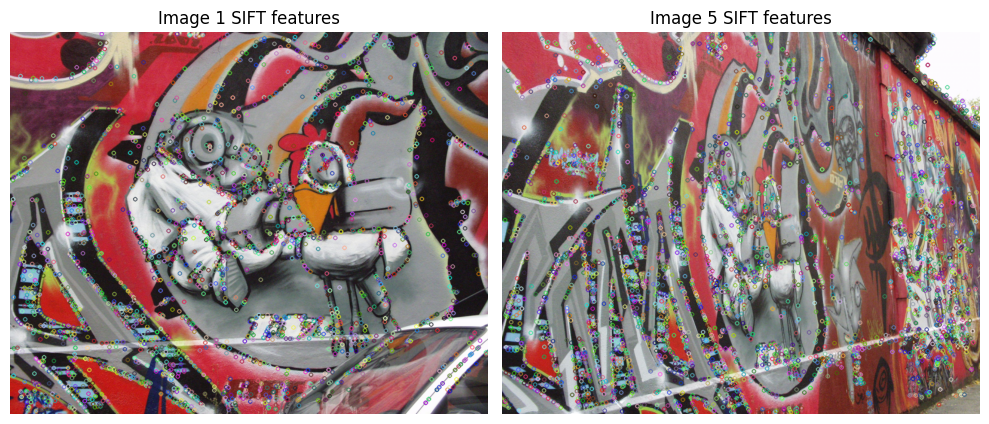

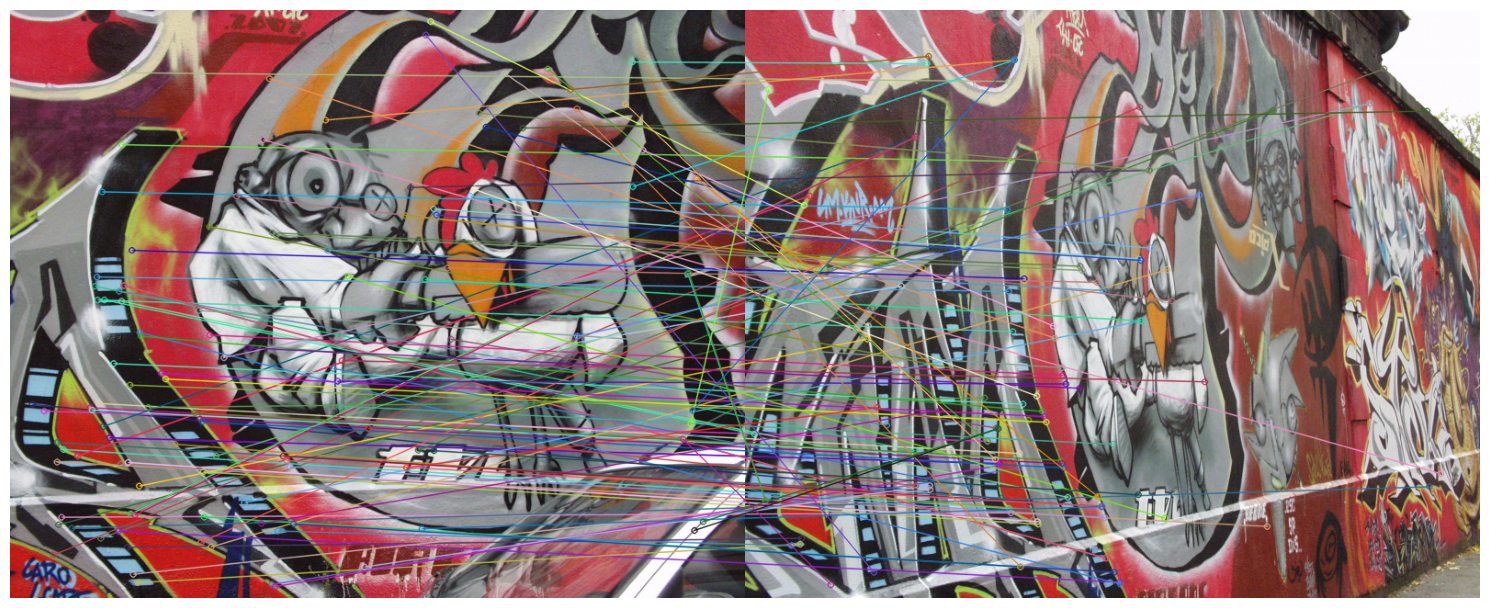

In [53]:
img1 = cv.imread("images/graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img5 = cv.imread("images/graf/img5.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

features = sift_feature_matching(img1, img5, plot = True)

b.

Best no. of inliers = 692
Best no. of inliers = 597
Best no. of inliers = 639
Best no. of inliers = 487


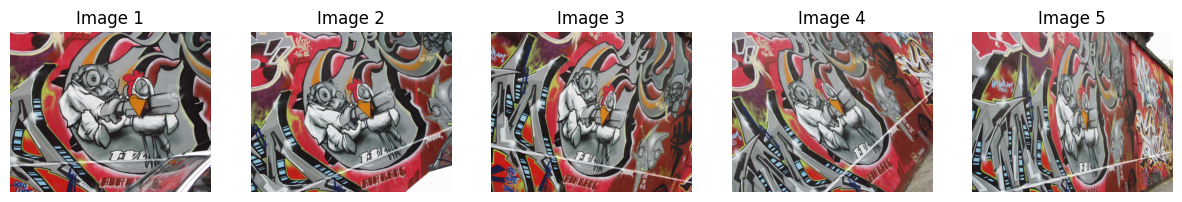

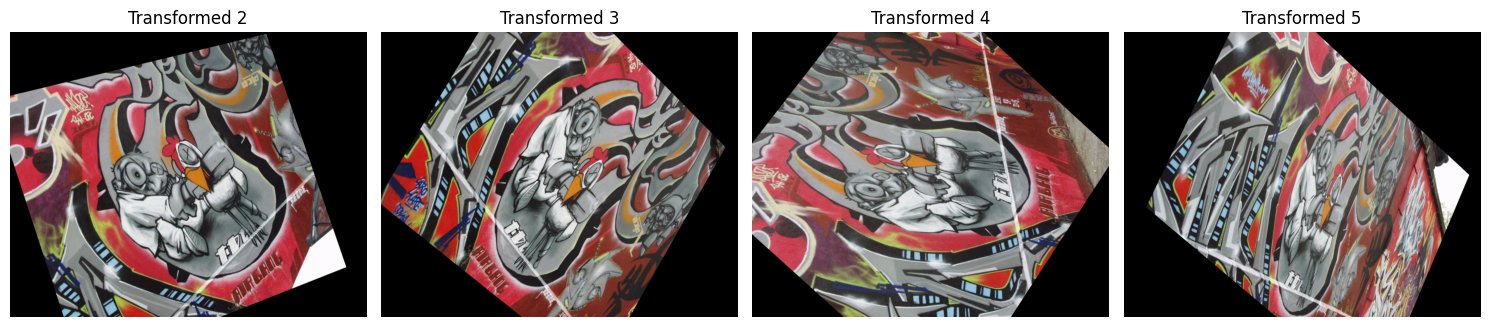

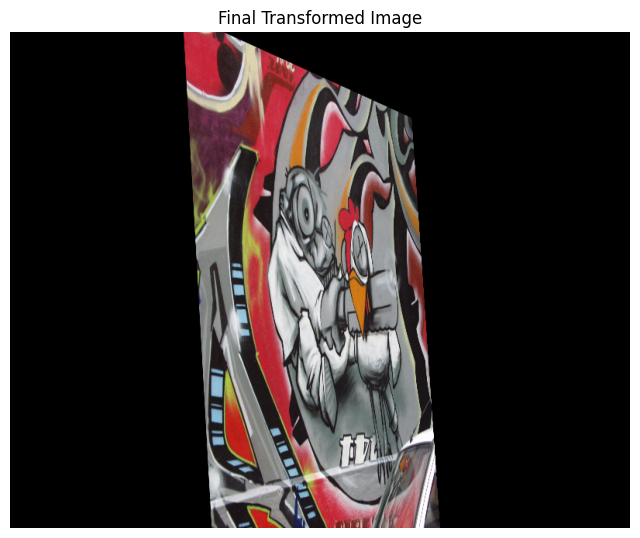

<ProjectiveTransform(matrix=
    [[ 6.56075847e-01, -3.90426836e-01,  2.96911406e+02],
     [ 5.80699349e-01,  7.80266054e-01, -1.23336255e+02],
     [ 7.81102227e-05, -6.97442141e-05,  1.00000000e+00]])>


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import transform

# Set random seed and padding
np.random.seed(62)
pad = 100

# Load and display the images
images = []
plt.figure(figsize=(15, 10))
for i in range(1, 6):
    img = cv.imread(f"images/graf/img{i}.ppm")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis('off')

# Initialize the cumulative transformation matrix
final_transform = transform.ProjectiveTransform(np.eye(3))

# Sequentially transform images
plt.figure(figsize=(15, 10))
for i in range(1, 5):
    img1, img2 = images[i-1], images[i]
    
    # Extract SIFT features and compute homography between img1 and img2
    good_matches, kp1, kp5 = sift_feature_matching(img1, img2)
    tform, _ = find_best_homography(good_matches, kp1, kp5)
    
    # Apply transformation to img2
    transformed_image = transform.warp(images[i], tform.inverse)

    # Update the cumulative transformation
    final_transform = final_transform + tform

    # Display transformed image
    plt.subplot(1, 4, i)
    plt.imshow(transformed_image)
    plt.title(f"Transformed {i+1}")
    plt.axis('off')

plt.tight_layout()

# Apply final transformation to the first image and display
final_image = transform.warp(images[0], final_transform.inverse)

plt.figure(figsize=(8, 8))
plt.imshow(final_image)
plt.title("Final Transformed Image")
plt.axis('off')
plt.show()

print(tform)


c.

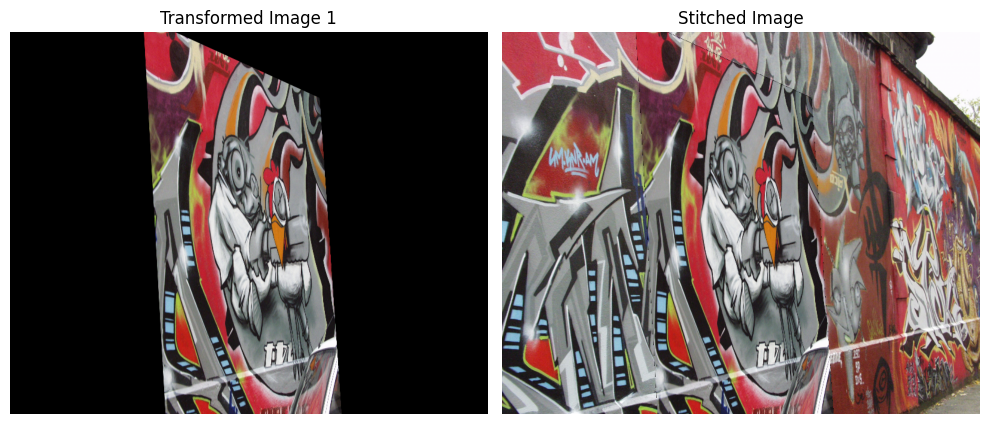

In [54]:
# Apply final transformation to the first image
final_transformed_image = transform.warp(images[0], final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)

# Create a mask and stitch the transformed and reference images
mask = final_transformed_image == 0
stitched_image = mask * images[4] + final_transformed_image

# Plot the original, transformed, and stitched images
plt.figure(figsize=(10, 10))

titles = ["Image 1", "Image 5", "Transformed Image 1", "Stitched Image"]
images_to_plot = [images[0], images[4], final_transformed_image, stitched_image]

# for i in range(4):
#     plt.subplot(1, 4, i+1)
#     plt.imshow(images_to_plot[i])
#     plt.title(titles[i])
#     plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(final_transformed_image)
plt.title("Transformed Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()
